# Experiment A iii part 2: Sensitivity analysis - number of neurons 

Data obtained from Global Brain Dynamics Embed the Motor Command Sequence of Caenorhabditis elegans. Cell, 163(3), 656–669. http://doi.org/10.1016/j.cell.2015.09.034

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

**Experiment A iii part 2: Effect of number of neurons selected on SHRED performance.**
- randomly select 1 neuron from group with high variance
- randomly select 2 neuron from group with high variance
- randomly select 3 neuron from group with high variance
- randomly select 4 neuron from group with high variance
- randomly select 5 neuron from group with high variance



In [21]:
# Importing all dependencies 
import numpy as np
import numpy as np
import torch
import subprocess
import os
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import mne
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.interpolate import CubicSpline
from scipy.io import loadmat
from sklearn.linear_model import Ridge


In [22]:
#Importing packages
HOME_DIR = "/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/neuralSHRED"

SHRED_DIR = os.path.join(HOME_DIR, "sindy-shred-main")
import sys 
sys.path.append(SHRED_DIR)

from processdata import load_data
from processdata import TimeSeriesDataset
import sindy
import pysindy as ps
from pysindy.differentiation import FiniteDifference

os.environ["CUDA_VISIBLE_DEVICES"]="0"


# Data Format
- 5 worms
- 18 mins at roughly 2.85 samples per second --> ~3000 samples per trial
- 107 - 131 neurons

*Worm One, No Stim*

In [23]:
# Loading the Dataset
os.chdir("../")

data_path = os.path.join(HOME_DIR, 'worms/data/WT_NoStim.mat')
data = loadmat(data_path)
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'WT_NoStim', 'WT_Stim'])


In [24]:
# Working with the no stim condition -- WORM ONE
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][0][0] #3137 timepoints, 109 neurons 

time = no_stim[0][0][4]
dt = time[1][0] - time[0][0]

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][0][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][0][3][0][i][0])

sr = no_stim[0][0][6]
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][0][7][0][0][0]
SLOW = no_stim[0][0][7][0][0][1]
DT = no_stim[0][0][7][0][0][2]
VT = no_stim[0][0][7][0][0][3]
REV1 = no_stim[0][0][7][0][0][4]
REV2 = no_stim[0][0][7][0][0][5]
REVSUS = no_stim[0][0][7][0][0][6]
NOSTATE = no_stim[0][0][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('dt', dt)
print('sr', sr, 'Hz')


number timepoints(m) 3137 number neurons(n): 109
dt 0.34427797258527254
sr [[2.90462963]] Hz


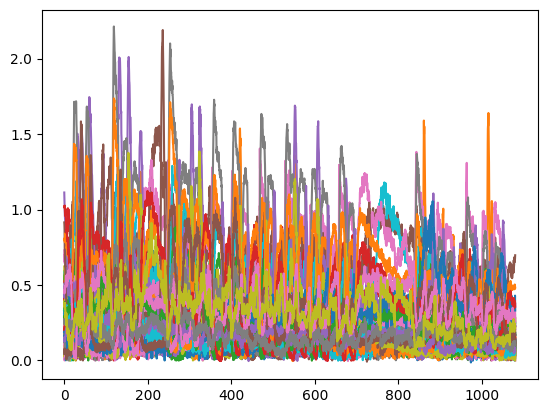

In [25]:
load_X = neuron_data_cor
plt.plot(time, load_X)
plt.show()

Preparing the data (use only first half)

(1568, 109)


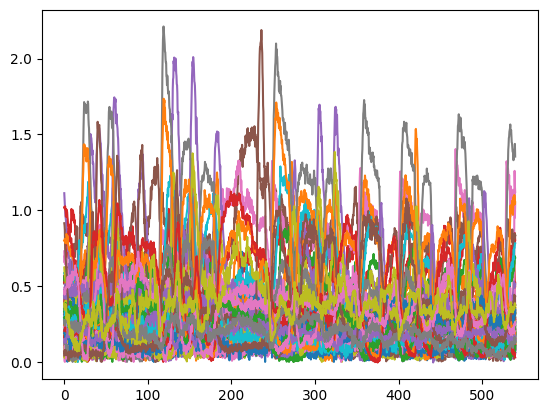

In [26]:
load_X = load_X[:int(m/2),:]
time = time[:int(m/2)].flatten()
print(load_X.shape)

plt.plot(time, load_X)
plt.show()

In [27]:
### Defining the train test split
lags = 100
new_m = int(m/2)
test_val_size = int(new_m * 0.2)
train_indices = np.arange(0, new_m - lags - test_val_size)
mask = np.ones(new_m - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, new_m - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[:int(test_val_size/2)]
test_indices = valid_test_indices[int(test_val_size/2):test_val_size]




Studying the variance of the neuronal activity

0.11572921109005503


<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/var/folders/vw/0t6vz1wn6rn5mgpcy6w188x00000gn/T/ipykernel_5242/2265880939.py:11: SyntaxWarning: invalid escape sequence '\s'
  plt.scatter(neuron_index, var, color = 'black', label = '$\sigma$')
/var/folders/vw/0t6vz1wn6rn5mgpcy6w188x00000gn/T/ipykernel_5242/2265880939.py:14: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma$', fontsize = 16)


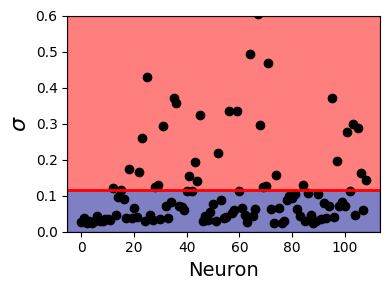

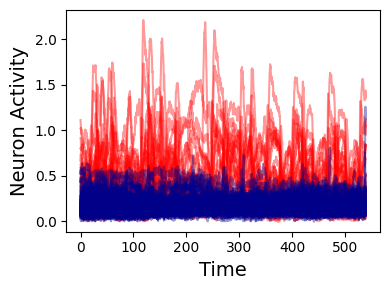

In [28]:
# Splitting into high and low variance groups
var = np.std(load_X[train_indices], axis = 0)
var_ave = np.mean(var)
print(var_ave)
neuron_index = np.arange(var.shape[0])

#plotting the distribution of std 
plt.figure(figsize = (4,3))
plt.axhspan(0, var_ave, color='darkblue', alpha=0.5)
plt.axhspan(var_ave,0.6 ,color='red', alpha=0.5)
plt.scatter(neuron_index, var, color = 'black', label = '$\sigma$')
plt.axhline(var_ave, color = 'red', linewidth = 2)
plt.xlabel('Neuron', fontsize = 14)
plt.ylabel('$\sigma$', fontsize = 16)
plt.ylim((0,0.6))
plt.tight_layout()
plt.show()


# Finding indices for high variance cases
high_ind = np.where(var > var_ave)[0]
low_ind = np.where(var < var_ave)[0]
plt.figure(figsize = (4,3))
plt.plot(time, load_X[:,high_ind], color = 'red', alpha = 0.4)
plt.plot(time, load_X[:,low_ind], color = 'darkblue', alpha = 0.4)
plt.xlabel('Time', fontsize = 14)
plt.ylabel('Neuron Activity', fontsize = 14)
plt.tight_layout()




### Selecting different number of neurons

In [12]:
latent_dim = 32
poly_order = 1
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)
import sindy_shred

num_neurons = np.array([1,2,3,4,5])

## high variance
for z in range(3,5):
    for k in range(15):
        # Randomly select the neurons to train the SHRED model on
        indices = np.random.choice(high_ind.shape[0], size= num_neurons[z], replace=False) 
        neuron_locations = high_ind[indices]
        file_path = os.path.join(HOME_DIR, f'worms/data_output/exp_Aiii_pt2/{z+1}_neuron/neuron_loc_{k+1}.npy')
        print(file_path)
        np.save(file_path, neuron_locations)
        sc = MinMaxScaler()
        sc = sc.fit(load_X[train_indices])
        transformed_X = sc.transform(load_X)

        ### Generate input sequences to a SHRED model
        all_data_in = np.zeros((new_m - lags, lags, num_neurons[z]))
        for i in range(len(all_data_in)):
            all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

        ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
        valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
        test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

        ### -1 to have output be at the same time as final sensor measurements
        train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
        valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
        test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

        train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
        valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
        test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

        shred = sindy_shred.SINDy_SHRED(num_neurons[z], n, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                        library_dim=library_dim, poly_order=poly_order,
                                        include_sine=include_sine, dt=dt, layer_norm=False).to(device)

        validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200,
                                            lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=10.0,
                                            optimizer="AdamW", thres_epoch=100)
        
        test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
        test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
        mse_test = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
        print('mse test', mse_test)
        train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
        train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
        mse_train = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)
        print('mse train', mse_train)


        file_path = os.path.join(HOME_DIR, f'worms/data_output/exp_Aiii_pt2/{z+1}_neuron/train_recon_{k+1}.npy')
        np.save(file_path, train_recons)
        file_path = os.path.join(HOME_DIR, f'worms/data_output/exp_Aiii_pt2/{z+1}_neuron/test_recon_{k+1}.npy')
        np.save(file_path, test_recons)
        file_path = os.path.join(HOME_DIR, f'worms/data_output/exp_Aiii_pt2/{z+1}_neuron/train_gt_{k+1}.npy')
        np.save(file_path, train_ground_truth)
        file_path = os.path.join(HOME_DIR, f'worms/data_output/exp_Aiii_pt2/{z+1}_neuron/test_gt_{k+1}.npy')
        np.save(file_path, test_ground_truth)
        file_path = os.path.join(HOME_DIR, f'worms/data_output/exp_Aiii_pt2/{z+1}_neuron/mse_{k+1}.npy')
        np.save(file_path, [mse_train, mse_test])


/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/neuralSHRED/worms/data_output/exp_Aiii_pt2/4_neuron/neuron_loc_1.npy
1 : tensor(0.0668, grad_fn=<AddBackward0>)
2 : tensor(0.0490, grad_fn=<AddBackward0>)
3 : tensor(0.0475, grad_fn=<AddBackward0>)
4 : tensor(0.0463, grad_fn=<AddBackward0>)
5 : tensor(0.0450, grad_fn=<AddBackward0>)
6 : tensor(0.0436, grad_fn=<AddBackward0>)
7 : tensor(0.0400, grad_fn=<AddBackward0>)
8 : tensor(0.0391, grad_fn=<AddBackward0>)
9 : tensor(0.0373, grad_fn=<AddBackward0>)
10 : tensor(0.0346, grad_fn=<AddBackward0>)
11 : tensor(0.0337, grad_fn=<AddBackward0>)
12 : tensor(0.0311, grad_fn=<AddBackward0>)
13 : tensor(0.0295, grad_fn=<AddBackward0>)
14 : tensor(0.0307, grad_fn=<AddBackward0>)
15 : tensor(0.0316, grad_fn=<AddBackward0>)
16 : tensor(0.0281, grad_fn=<AddBackward0>)
17 : tensor(0.0266, grad_fn=<AddBackward0>)
18 : tensor(0.0253, grad_fn=<AddBackward0>)
19 : tensor(0.0236, grad_fn=<AddBackward0>)
20 : tensor(0.0226, grad_fn=<AddBackward0>)
21 : tens

## Importing and Plotting the data

In [29]:
n_trials = 15


1
2
3
4
5


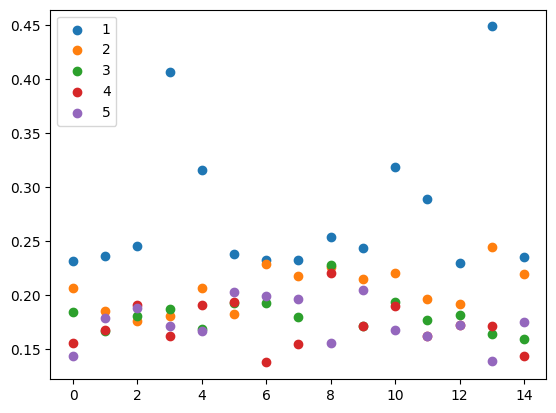

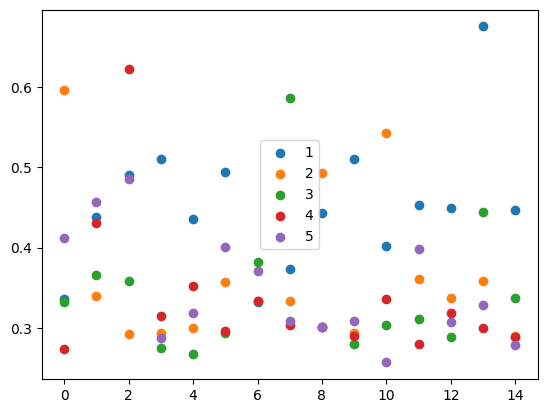

In [33]:
label = ["1", "2" , "3", "4", "5"]
train_mse = {}
test_mse = {}

for i in range(len(label)):
    train_mse[label[i]] = []
    test_mse[label[i]] = []
    print(label[i])
    for k in range(n_trials):
        neuron_loc = np.load(os.path.join(HOME_DIR, f"worms/data_output/exp_Aiii_pt2/{label[i]}_neuron/neuron_loc_{k+1}.npy"))
        train_recons = np.load(os.path.join(HOME_DIR, f"worms/data_output/exp_Aiii_pt2/{label[i]}_neuron/train_recon_{k+1}.npy"))
        train_gt = np.load(os.path.join(HOME_DIR, f"worms/data_output/exp_Aiii_pt2/{label[i]}_neuron/train_gt_{k+1}.npy"))
        test_recons = np.load(os.path.join(HOME_DIR, f"worms/data_output/exp_Aiii_pt2/{label[i]}_neuron/test_recon_{k+1}.npy"))
        test_gt = np.load(os.path.join(HOME_DIR, f"worms/data_output/exp_Aiii_pt2/{label[i]}_neuron/test_gt_{k+1}.npy"))

        mask = np.ones(train_gt.shape[1], dtype=bool)
        mask[neuron_loc] = False
        train_ex = train_recons.T[mask]
        train_gt_ex = train_gt.T[mask]
        mask = np.ones(test_gt.shape[1], dtype=bool)
        mask[neuron_loc] = False
        test_ex = test_recons.T[mask]
        test_gt_ex = test_gt.T[mask]
        mse_train = np.linalg.norm(train_ex - train_gt_ex) / np.linalg.norm(train_gt_ex)
        mse_test = np.linalg.norm(test_ex - test_gt_ex) / np.linalg.norm(test_gt_ex)
        train_mse[label[i]].append(mse_train)
        test_mse[label[i]].append(mse_test)

for z in range(len(label)):
    plt.scatter(np.arange(n_trials),train_mse[label[z]], label = label[z])
plt.legend()
plt.show()


for z in range(len(label)):
    plt.scatter(np.arange(n_trials),test_mse[label[z]], label = label[z])
plt.legend()

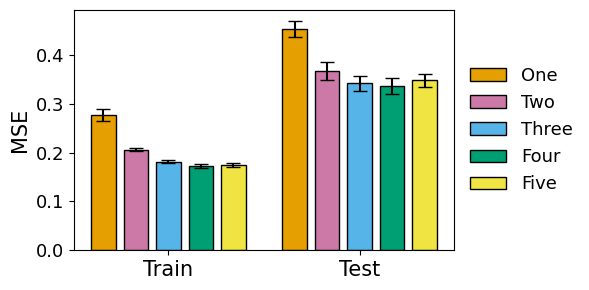

In [35]:
mean_one = [np.mean(train_mse[label[0]]), np.mean(test_mse[label[0]])]
mean_two = [np.mean(train_mse[label[1]]), np.mean(test_mse[label[1]])]
mean_three = [np.mean(train_mse[label[2]]), np.mean(test_mse[label[2]])]
mean_four = [np.mean(train_mse[label[3]]), np.mean(test_mse[label[3]])]
mean_five = [np.mean(train_mse[label[4]]), np.mean(test_mse[label[4]])]

std_one = [np.std(train_mse[label[0]])/5, np.std(test_mse[label[0]])/5]
std_two = [np.std(train_mse[label[1]])/5, np.std(test_mse[label[1]])/5]
std_three = [np.std(train_mse[label[2]])/5, np.std(test_mse[label[2]])/5]
std_four = [np.std(train_mse[label[3]])/5, np.std(test_mse[label[3]])/5]
std_five = [np.std(train_mse[label[4]])/5, np.std(test_mse[label[4]])/5]


x = np.arange(len(mean_one))
labels = ['Train', 'Test']

colors = [
    "#E69F00",  # orange
    "#CC79A7",  # reddish purple
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#999999"   # gray
]
fig, ax = plt.subplots(figsize = (6,3))


ax.bar(x-0.34, mean_one, yerr=std_one, capsize=5, width = 0.128,
              edgecolor='black', facecolor=colors[0], linewidth=1)
ax.bar(x-0.17, mean_two, yerr=std_two, capsize=5, width = 0.128,
              edgecolor='black', facecolor=colors[1], linewidth=1)
ax.bar(x,     mean_three, yerr=std_three, capsize=5, width = 0.128,
              edgecolor='black', facecolor=colors[2], linewidth=1)
ax.bar(x+0.17, mean_four, yerr=std_four, capsize=5, width = 0.128,
              edgecolor='black', facecolor=colors[3], linewidth=1)
ax.bar(x+0.34, mean_five, yerr=std_five, capsize=5, width = 0.128,
              edgecolor='black', facecolor=colors[4], linewidth=1)


# Customize ticks and labels
ax.set_xticks(x)
ax.tick_params(axis='y', labelsize=13)

ax.set_xticklabels(labels, fontsize = 15)
ax.set_ylabel("MSE", fontsize = 15)
plt.legend(['One', 'Two', 'Three', 'Four', 'Five'],loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, fontsize = 13)

plt.tight_layout()
plt.savefig(os.path.join(HOME_DIR, f'worms/data_output/figs/mse_bar_neuron.png'), transparent=True, dpi=500)

plt.show()
